<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Cell_Pose_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.3 MB 2.1 MB/s 
     |████████████████████████████████| 829 kB 29.1 MB/s 
     |████████████████████████████████| 132 kB 40.0 MB/s 
     |████████████████████████████████| 1.3 MB 45.3 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 9.3 MB 43.4 MB/s 
     |████████████████████████████████| 140 kB 47.4 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628162 sha256=ad9a5b34655a92cd0183bb274d64ec737d6772ad2f348980d235b12a866647a6
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=0bd467acefe020c8bd58e491391772395d433f633f589c0dce5fdfd23002590d
  Stored in directory: /root/.cache/pip/wheels/56/b0/

In [2]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


--2022-10-19 18:55:07--  https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa [following]
--2022-10-19 18:55:08--  https://www.dropbox.com/sh/raw/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc708253ff1fa4ec5e4a8f2e3bba.dl.dropboxusercontent.com/zip_download_get/BSgxsPzK95-p739sJhdPQ879ALU74nf17BNY3JzpVIjJE51SPow9GPVdbvMayThFlvMQW7yglBfp1psNLfuJa1_6x3al-cVKCmKERb46b0IX4g# [following]
--2022-10-19 18:55:08--  https://uc708253ff1fa4ec5e4a8f2e3bba.dl.dropboxusercontent.com/zip_download_get/BSgxsPzK95-p739sJhdPQ879ALU74nf17BNY3JzpVIjJE51SPow9GPVdbvMayThFlvMQW7yglBfp1psNLfuJa1_6x3al

In [3]:
im_num = 2
print(file_list[im_num])
my_reader = bioformats.get_image_reader('my_image', file_list[im_num])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir
800 800 3 17
(800, 800, 3, 17)


In [4]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 5.0 MB/s 
     |████████████████████████████████| 31.0 MB 13.5 MB/s 
     |████████████████████████████████| 4.2 MB 14.0 MB/s 


In [5]:
image=image[:,:,:,1:]

In [8]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
ch_names = ['target','mCherry','NeuN']

'''Transpose ndims, preserve labels'''
dim_order = np.arange(image.ndim).tolist()
dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

'''Normalize channel intensities'''
image_r=np.transpose(image,dim_order)
ch_val_list = []
for ch in range(image_r.shape[chan_dim]):    
    ch_val = image_r[ch,:,:,:]
    for zi in range(image_r.shape[z_dim]):
        ch_val_z = ch_val[zi,:,:]
        ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten())
        ch_val[zi,:,:] = ch_val_z
    # ch_z = (ch_val-np.mean(ch_val.flatten())) / np.std(ch_val.flatten())
    ch_val_list.append(ch_val)
image_znorm = np.stack(ch_val_list,axis=0)


'''Generate Masks with Cellpose'''
model = models.Cellpose(model_type='cyto')
masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
masks=masks.astype(float)
# nan_masks_id = masks.copy().astype(float)
# nan_masks_id[masks==0]=np.nan
# nan_masks_bin = nan_masks_id>0
# nan_masks_bin = nan_masks_bin.astype(float)
# nan_masks_bin[masks==0.]=np.nan
# masked_composite = image_r*np.stack([nan_masks_bin>0] * 3,axis=0)

# '''Normalize Cell intensities'''
# ch_val_list = []
# for ch in range(masked_composite.shape[chan_dim]):    
#     ch_val = image_r[ch,:,:,:]*nan_masks_bin
#     ch_z = (ch_val-np.nanmean(ch_val.flatten())) / np.nanstd(ch_val.flatten())
#     ch_val_list.append(ch_z)
# masked_composite_znorm = np.stack(ch_val_list,axis=0)



100%|██████████| 25.3M/25.3M [00:00<00:00, 60.2MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 1.93MB/s]


NameError: ignored

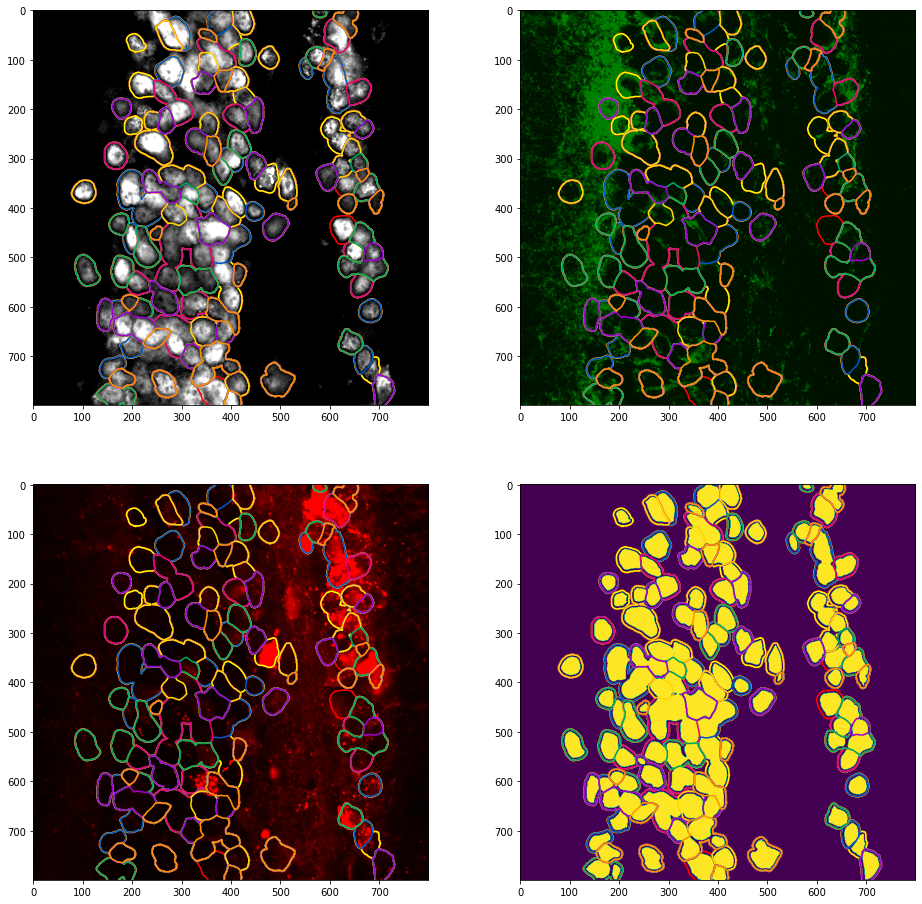

In [66]:
zi = 9
n=2
psize = 8
fig, axs = plt.subplots(n,2,figsize=(psize*2,psize*n))
axs=axs.flatten()

exp_masks = masks.copy()
for zi in range(masks.shape[0]):
    exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=5)




axs[0].imshow(image_znorm[2,zi,:,:],cmap='gray',vmax=3)
axs[0].contour(exp_masks[zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[1].imshow(image_znorm[0,zi,:,:],cmap=cmap,vmin=-1, vmax=3)
axs[1].contour(exp_masks[zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[2].imshow(image_znorm[1,zi,:,:],cmap=cmap, vmax=4)
axs[2].contour(exp_masks[zi,:,:],cmap='prism')

axs[3].imshow(masks[zi,:,:]>0)
axs[3].contour(exp_masks[zi,:,:],cmap='prism')
# fig.suptitle(file_list[im_num])
plt.show()

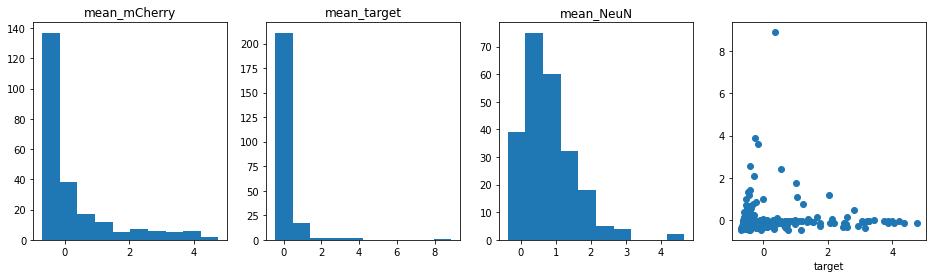

P(G|~R) 0.28289473684210525
P(G|R) 0.1566265060240964
P(R|G) 0.23214285714285715
P(R|~G) 0.39106145251396646
odds ratio 0.4707641196013289


In [67]:
# import pandas as pd
# '''Quantify Cell Intensities'''
# cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
# cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
# for ch in range(image_znorm.shape[chan_dim]):
#     for cell in cell_df.index:
#         cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
#         cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
# cell_df.head()

sp_size =4
n=4
fig, ax = plt.subplots(1,n,figsize=(n*sp_size,sp_size))
ax=ax.flatten()
_=ax[0].hist(cell_df['mean_mCherry'])
ax[0].title.set_text('mean_mCherry')
_=ax[1].hist(cell_df['mean_target'])
ax[1].title.set_text('mean_target')
_=ax[2].hist(cell_df['mean_NeuN'])
ax[2].title.set_text('mean_NeuN')

ax[3].scatter(cell_df['mean_mCherry'],cell_df['mean_target'])
ax[3].set_xlabel('mCherry')
ax[3].set_xlabel('target')
plt.show()


is_green = cell_df['mean_target']>0
not_green = cell_df['mean_target']<=0
is_red = cell_df['mean_mCherry']>0
not_red = cell_df['mean_mCherry']<=0


p_G_nR = np.mean(  is_green[not_red]  )
p_G_iR = np.mean(  is_green[is_red]  )
print('P(G|~R)',p_G_nR)
print('P(G|R)',p_G_iR)

p_R_iG = np.mean(  is_red[is_green]  )
p_R_nG = np.mean(  is_red[not_green]  )
print('P(R|G)',p_R_iG)
print('P(R|~G)',p_R_nG)


num_RnG = np.sum(is_red[not_green] )
num_nRnG = np.sum(not_red[not_green] )
num_RG = np.sum(is_red[is_green] )
num_nRG = np.sum(not_red[is_green] )
OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
print('odds ratio',OR)

In [17]:
def 